In [1]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean

In [2]:
city = 'Bhopal'
month = 'Dec'
PATH = f'/media/root/data/analysis/data/Item_wise_data/{city}/'
t100 = time.time()

In [3]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Driver_Shift', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = round(df['prep_time']/np.timedelta64(1, 's')).astype(int) + 7*60
print(df.shape)
df.head()

(84558, 29)
(84558, 9)
(84558, 10)


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
6213,DPI66221,2021-12-17,1,2021-12-17 10:58:16.347,2021-12-17 10:58:31.240,BRD0020,BR-Garlic Breadsticks,1,2021-12-17 11:16:48.000,435
24613,DPI66221,2021-12-17,1,2021-12-17 10:58:16.347,2021-12-17 10:58:30.833,PIZ0117,_SV-Margherita,1,2021-12-17 11:16:48.000,434
22037,DPI66373,2021-12-17,1,2021-12-17 10:58:35.500,2021-12-17 11:03:52.823,PIZ0140,PM Loaded VG,1,2021-12-17 11:18:53.000,737
28753,DPI66373,2021-12-17,1,2021-12-17 10:58:35.500,2021-12-17 11:03:53.140,PIZ5127,PM Loaded NV,1,2021-12-17 11:18:53.000,738
36383,DPI66449,2021-12-17,1,2021-12-17 11:01:13.280,2021-12-17 11:02:13.377,PIZ0134,Pizza Mania Tomato,1,2021-12-17 11:09:38.457,480


In [5]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = df['Location_Code'].unique()
# allMenuCodes, allStoreIds

In [6]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [7]:
sampleItem

Location_Code                             DPI66221
Order_Date                              2021-12-17
Order_Number                                     1
Kitchen_Display_Time    2021-12-17 10:58:16.347000
Oven_Time               2021-12-17 10:58:31.240000
Menu_Code                                  BRD0020
Item Description             BR-Garlic Breadsticks
Quantity                                         1
Delivery_Time              2021-12-17 11:16:48.000
prep_time                                      435
Name: 6213, dtype: object

In [8]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if(stores[i] == storeId):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        return [item['Location_Code']]

In [9]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

['DPI66221']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
# Feature 2: Item Type
def getOneHotEncodingItem(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodingItem(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if (items[i] == item):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, isOneHotEncodingRequired=False, clubCategoryWise=False):
    if (not isOneHotEncodingRequired):
        if clubCategoryWise:
            return [item['Menu_Code'][0:3]]
        return [item['Menu_Code']]
    else:
        return getOneHotEncodingItem(item['Menu_Code'], allMenuCodes, clubCategoryWise)

In [11]:
print(getItemType(sampleItem))
print(getItemType(sampleItem, True))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True, True))

['BRD0020']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['BRD']
[1, 0, 0, 0, 0, 0, 0]


In [12]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if isOneHotEncodingRequired:
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [timeslot]

In [13]:
def get_preparation_time(item):
    return item['prep_time']
# 	diff = item['Oven_Time'] - item['Kitchen_Display_Time']
# 	return diff.total_seconds() + 7*60

In [14]:
#DON"T RUN IT AGAIN AND AGAIN, it will take much more time
# Feature 4 : Count of all baking items of all orders received by the store in the last 20 minutes.

# Pre-preparation of data
df['pre_prep_time'] = 0

StoreWiseItems = {}
for index, item in df.iterrows():
    store = item['Location_Code']
    if store in StoreWiseItems:
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTime = dtKitchenDisplay - timedelta(minutes=60)
        count = 0
        pt = 0
        for i in reversed(range(len(StoreWiseItems[store]))):
            if(StoreWiseItems[store][i]['Kitchen_Display_Time'] >= lastTime and StoreWiseItems[store][i]['Kitchen_Display_Time'] < dtKitchenDisplay):
                if(StoreWiseItems[store][i]['Menu_Code'] == item['Menu_Code']):
                    pt += get_preparation_time(item)
                    count+=1
            else:
                break
        if count != 0:
            df['pre_prep_time'][index] = pt/count
        else:
            df['pre_prep_time'][index] = 10*60
        StoreWiseItems[store].append(item)
    else:
        StoreWiseItems[store] = [item]
        df['pre_prep_time'][index] = 10*60

        
storeWiseCumulativeItems = {}
StoreWiseDFs = {}
for store in StoreWiseItems.keys():
    StoreWiseDFs[store] = pd.DataFrame.from_dict(StoreWiseItems[store])
    storeWiseCumulativeItems[store] = {}

# item count per slot
for store in StoreWiseItems.keys():
    for item in StoreWiseItems[store]:
        date = item['Order_Date']
        minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
        if date in storeWiseCumulativeItems[store]:
            storeWiseCumulativeItems[store][date][minuteSlot]+=1
        else:
            t = []
            for i in range(0, 24*60):
                t.append(0)
            storeWiseCumulativeItems[store][date] = t
            storeWiseCumulativeItems[store][date][minuteSlot] = 1
            
#prefix sum            
for store in storeWiseCumulativeItems.keys():
    for date in storeWiseCumulativeItems[store].keys():
        for i in range(1, 24*60):
            storeWiseCumulativeItems[store][date][i] += storeWiseCumulativeItems[store][date][i-1]
            
            
def countPastOrders(item, storeWiseCumulativeItems=storeWiseCumulativeItems, slotTime=30):
    minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
    total = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][minuteSlot]
    prev = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][max(minuteSlot-slotTime, 0)]
    return [(total-prev)]

/tmp/ipykernel_57309/2016951000.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_57309/2016951000.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_57309/2016951000.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = pt/count


In [15]:
print("time = StoreWiseItems and countPastOrders", time.time()-t100)

# print(countPastOrders(sampleItem))
# print(countPastOrders(sampleItem, slotTime=10))

d = datetime.strptime('2021-12-20 00:00:00', '%Y-%m-%d %H:%M:%S')
# storeWiseCumulativeItems[sampleItem['Location_Code']][d]

time = StoreWiseItems and countPastOrders 881.8132450580597


In [16]:
# type(StoreWiseItems[sampleItem['Location_Code']])

In [17]:
# Feature 5 : Avg prep time of the same item in the same store in last 60 minutes.

def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
    orderedItem = item['Menu_Code']
    prepTime = []
    if clubCategoryWise:
        orderedItem = orderedItem[0:3]
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
             & (d['Kitchen_Display_Time'] >= lastTime) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]

    if(len(tdf)>0):
        return [tdf['prep_time'].mean()]
    else:
        return [10*60]


# def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
#     dtKitchenDisplay = item['Kitchen_Display_Time']
#     lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
#     orderedItem = item['Menu_Code']
#     prepTime = []
#     if clubCategoryWise:
#         orderedItem = orderedItem[0:3]
#     tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
#              & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]

#     if(len(tdf)>0):
#         return [tdf['prep_time'].mean()]
#     else:
#         return [10*60]

    
# Feature 6 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    
#     prepTime = []
#     tdf = df[(df['Location_Code']==item['Location_Code']) & \
#              (df['Oven_Time'] >= dtKitchenDisplay) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    return len(tdf.index)
#     for order in StoreWiseItems[item['Location_Code']]:
#         if(order['Kitchen_Display_Time'] >= lastTime and order['Kitchen_Display_Time'] <= dtKitchenDisplay):
#             if (order['Menu_Code'][0:len(orderedItem)] == orderedItem):
#                 prepTime.append(get_preparation_time(order))
#     if(len(prepTime) > 0):
#         return [mean(prepTime)]
#     else:
#         return [10*60] # POINT OF DISCUSSION, For now taking 10 minutes

In [18]:
getPreviousPrepTime(sampleItem, StoreWiseItems, False, 60)
lengthQueue(sampleItem)

2

In [19]:
item = sampleItem
orderedItem = item['Menu_Code']
orderedItem = orderedItem[0:3]
dtKitchenDisplay = item['Kitchen_Display_Time']
lastTime = dtKitchenDisplay - timedelta(minutes=60)
tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
         & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
# print(item, len(tdf)) 
# if(len(tdf)>0):
#     print([round(tdf['prep_time'].mean())])
# tdf

In [20]:
# global variables

isThresholdForPreparationTime = False
thresholdForPreparationTime = 30 # minutes for preparation time (threshold)

clubItemsCategoryWise = False

splitMethod = 'random'
slotTimeForPastOrders = 20 # minutes

model = 'RF'
isOneHotEncodingRequired = True
isNormalizationRequired = True

print("time preprocess start", time.time()-t100)

time preprocess start 881.9418926239014


In [21]:
X_train, X_test, y_train, y_test = [], [], [], []
X = []
y = []
import time
t1 = t2 = t3 = t4 = t5 = t6 = t7 = 0
i = 0
for index, item in df.iterrows():
    i+=1
#     if(i%5000==0): print(t1, t2, t3, t4, t5, t6, t7)
    if(isThresholdForPreparationTime and (get_preparation_time(item) > thresholdForPreparationTime*60)): #removing inputs 
        continue
        
    features = []
    t = time.time()
    features = features + getStoreId(item, isOneHotEncodingRequired)
    t1 += time.time() - t
    
    t = time.time()
    features = features + getItemType(item, isOneHotEncodingRequired=isOneHotEncodingRequired, clubCategoryWise=clubItemsCategoryWise)
    t2 += time.time() - t

    t = time.time()    
    features = features + getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=isOneHotEncodingRequired)
    t3 += time.time() - t

    t = time.time()
    features = features + countPastOrders(item, storeWiseCumulativeItems, slotTimeForPastOrders) 
    t4 += time.time() - t

    t = time.time()
    features = features + getPreviousPrepTime(item, clubCategoryWise=clubItemsCategoryWise, timeslot = 60)  
    t5 += time.time() - t

    t = time.time()        
    features = features + [lengthQueue(item)]
    t6 += time.time() - t
    
    t = time.time()
    X.append(features)
    y.append(get_preparation_time(item))
    t7 += time.time() - t

#     if((order['ORDER_DATE'] >='2021-12-20' and order['ORDER_DATE'] <= '2021-12-24') or (order['ORDER_DATE'] >='2021-12-27' and order['ORDER_DATE'] <= '2021-12-29')):
#         X_train.append(features)
#         y_train.append(420+round(get_preparation_time(order)))
#     elif(order['ORDER_DATE'] =='2021-12-30'):
#         X_test.append(features)
#         y_test.append(420+round(get_preparation_time(order)))
print(t1, t2, t3, t4, t5, t6, t7)
print("time preprocess Done", time.time()-t100)

2.57382869720459 2.4161007404327393 4.6590282917022705 131.30924081802368 363.7638490200043 99.43306875228882 1.9860913753509521
time preprocess Done 1497.0461070537567


In [22]:
if splitMethod == 'random':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [23]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [24]:
# random forest
if (model=='RF'):
    print("Random Forest Model")
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    print("RMSE score on train set: ", getRMSE(y_train, predictions))
        
    predictions = regressor.predict(X_test)
    print("RMSE score on test set: ", getRMSE(y_test, predictions))

print("time trainin done", time.time()-t100)

Random Forest Model
RMSE score on train set:  15.459238674688986
RMSE score on test set:  40.61803529518052
time trainin done 1600.7445223331451


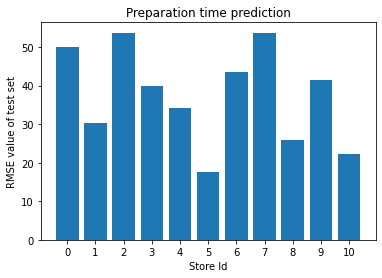

In [25]:
X_t = []
Y_t = []
for j in range(0, len(allStoreIds)):
    xx = []
    yy = []
    for i in range(0, len(X_test)):
        if(X_test[i][j] > 0):
            xx.append(X_test[i])
            yy.append(y_test[i])
    X_t.append(j)
    Y_t.append(getRMSE(yy, regressor.predict(xx)))
    
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.savefig(f'plots/{city}_{month}_1.png')
# plt.show()

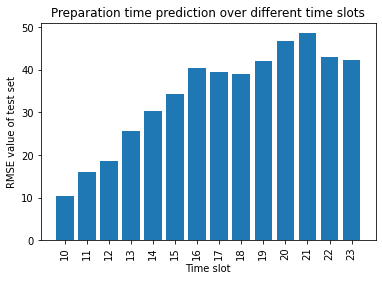

In [26]:
X_Axis = [i for i in range(10, 24)]
RMSETimeSlotWise = {}
total_items = len(allMenuCodes)+len(allStoreIds)
for x in X_Axis:
    x1 = []
    y1 = []
    for i in range(0, len(X_test)):
        if(X_test[i][total_items+x] > 0):
            x1.append(X_test[i])
            y1.append(y_test[i])
    RMSETimeSlotWise[x] = getRMSE(y1, regressor.predict(x1))
    
X_axis = list(RMSETimeSlotWise.keys())
Y_axis = list(RMSETimeSlotWise.values())

plt.bar(X_axis, Y_axis)
plt.xticks(X_axis, rotation='vertical')
plt.xlabel("Time slot")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction over different time slots")
plt.savefig(f'plots/{city}_{month}_2.png')
# plt.show()

In [27]:
Y_t_all = Y_t
# Y_t_all

In [28]:
bakeup_X = X
bakeup_y = y

In [29]:
n = len(allStoreIds)
store_wise_X = [[] for _ in range(n)]
store_wise_y = [[] for _ in range(n)]

for j in range(n):
    for i in range(len(X)):
        if X[i][j] > 0:
            store_wise_X[j].append(X[i][n:])
            store_wise_y[j].append(y[i])

# store_wise_X = [[x for x in X] for j in range(n)]
# store_wise_X = [x for j in range(n) for _,y in zip(X,y) if x[j]>0]

In [30]:
l = []

for i in range(n):
    X = store_wise_X[i]
    y = store_wise_y[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    
#     print("Random Forest Model", i, len(y_train), len(y_test))
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    a = getRMSE(y_train, predictions)
#     print("RMSE score on train set: ", a)
    
    predictions = regressor.predict(X_test)
    b = getRMSE(y_test, predictions)
#     print("RMSE score on test set: ", b)
    l.append((a, b, len(y_train), len(y_test)))
# l

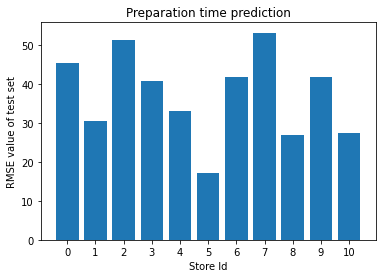

In [31]:
X_t = [i for i in range(len(allStoreIds))]
Y_t = [x[1] for x in l]
Y_t, X_t
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.savefig(f'plots/{city}_{month}_3.png')
# plt.show()
# Y_t

In [32]:
l2 = [(a**2)*b for _,a,_,b in l]
l3 = [b for _,_,_,b in l]
combine_rmse = (sum(l2)/sum(l3))**(1/2)
print("restwise rmse:", combine_rmse)

restwise rmse: 39.68633526294708


In [33]:
y = []
for i in X_t:
    y.append((Y_t[i], Y_t_all[i]))
#     print(i, Y_t[i], Y_t_all[i])

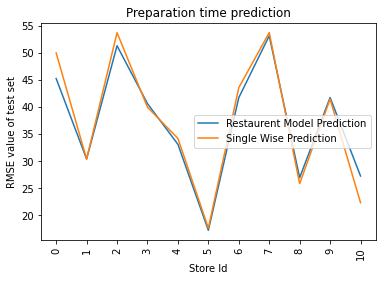

In [34]:
# plt.plot(X_t, Y_t, label = 'Single Model Prediction')
# plt.plot(X_t, Y_t_all, label = 'Restaurent Wise Prediction')

plt.plot(X_t, y)
plt.legend(['Restaurent Model Prediction', 'Single Wise Prediction'])

plt.xticks(X_t, rotation='vertical')
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.savefig(f'plots/{city}_{month}_4.png')
# plt.show()

In [ ]:
# dumping to file
import numpy as np
np.savetxt('Bhopal_Dec_X.txt', bakeup_X)
np.savetxt('Bhopal_Dec_y.txt', bakeup_y)